## Comparison of kriging function and results

In this notebook the kriging functions used in the gempy.assets.kriging module will be presented and compared to literature and other kriging tools. A simple 2D example will be used to provide maximum insight.

For more information see:

Webster, R. and Oliver, M. A. (2007). *Geostatistics for Environmental Scientists. Statistics
in Practice.* Wiley, Chichester, 2. ed edition. OCLC: 255943621.

Deutsch, C. V. and Journel, A. G. (1998). *GSLIB: Geostatistical Software Library and User's
Guide.* Oxford University Press, New York, version 2.0, 2nd edition.

To get *pykrige* and for its documentation, see:

http://pykrige.readthedocs.io/

In [1]:
# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

In [2]:
#ordinary kriging function, similar to the one used in module, returning weights
def ordinary_kriging(a, b, prop, range_, sill, nugget):

    shape = len(a)
    C = np.zeros((shape + 1, shape + 1))
    c = np.zeros((shape + 1))
    w = np.zeros((shape + 1))

    # filling matirces based on model for spatial correlation
    C[:shape, :shape] = exponential_variogram_model(b, range_, sill, nugget)
    c[:shape] = exponential_variogram_model(a, range_, sill, nugget)
    
    np.fill_diagonal(C,0)
    
    # matrix setup - compare pykrige, special for OK
    C[shape, :] = 1.0
    C[:, shape] = 1.0
    C[shape, shape] = 0.0
    c[shape] = 1.0

    # Solve Kriging equations
    w = np.linalg.solve(C, c)
    
    # calculating estimate and variance for kriging, variance is weird
    pred_var = w[shape] + np.sum(w[:shape] * c[:shape])
    result = np.dot(prop, w[:shape])
    
    return result, pred_var,w

In [3]:
# Reproduce literature example (x,y,value)
data = np.array([[0,0,7.0],[0,1,6.9],[0,2,7.9],[0,3,8.0],[1,0,6.0],[1,1,6.2],[1,2,8.0],[1,3,8.0],
                 [2,0,5.8],[2,1,6.2],[2,2,7.8],[2,3,8.0],[3,0,6.0],[3,1,6.2],[3,2,7.8],[3,3,8.0]])

# scale to correct spacing
data[:,0] = data[:,0]*40
data[:,1] = data[:,1]*40

# define target location of estimation
target = np.array([[1.5,1.5]])
target = target*40

# precalculate all distances for kriging
dist_all_to_all = cdist(data[:, :2], data[:, :2])
dist_target_to_all = cdist(target, data[:, :2])

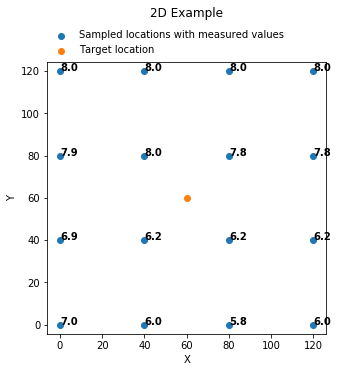

In [4]:
# Plot example case
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('2D Example', pad=45)
ax.scatter(data[:,0],data[:,1], label='Sampled locations with measured values')
ax.scatter(target[:,0],target[:,1], label='Target location')
ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=1, 
            borderaxespad=0, frameon=False)
ax.axis('equal')

for i, txt in enumerate(data[:,2]):
    ax.annotate(txt, (data[:,0][i],data[:,1][i]) ,weight='bold')


## Example A) Changing the nugget variance

In this example the nugget effect is increased incrementally. The total sill of the nested variogram is fixed at 0.382, the range is also kept constant at 90.53. Four different values for the nugget effect will be considered:
a) nugget = 0, b) nugget = 0.1, c) nugget = 0.3 d) nugget = sill (0.3.82). The corresponding nested variograms (exponential + nugget) are shown here:

In [5]:
def exponential_variogram_model(d, range_, sill, nugget):
    psill = sill- nugget 
    gamma = psill * (1. - np.exp(-d / (range_))) + nugget
    return gamma

Text(0.5, 1.0, 'Nested variograms with varying nugget variance')

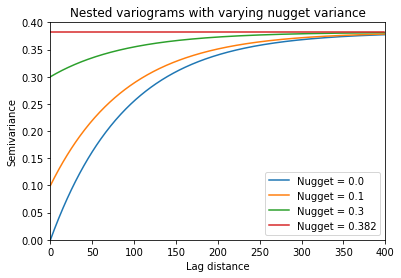

In [6]:
# Plot variograms
d = np.arange(0,400,1)
plt.plot(d, exponential_variogram_model(d, range_=90.53, sill=0.382, nugget=0), label="Nugget = 0.0")
plt.plot(d, exponential_variogram_model(d, range_=90.53, sill=0.382, nugget=0.1), label="Nugget = 0.1")
plt.plot(d, exponential_variogram_model(d, range_=90.53, sill=0.382, nugget=0.3), label="Nugget = 0.3")
plt.plot(d, exponential_variogram_model(d, range_=90.53, sill=0.382, nugget=0.382), label="Nugget = 0.382")
plt.xlim(0,400)
plt.ylim(0,0.4)
plt.legend()
plt.ylabel('Semivariance')
plt.xlabel('Lag distance')
plt.title('Nested variograms with varying nugget variance')

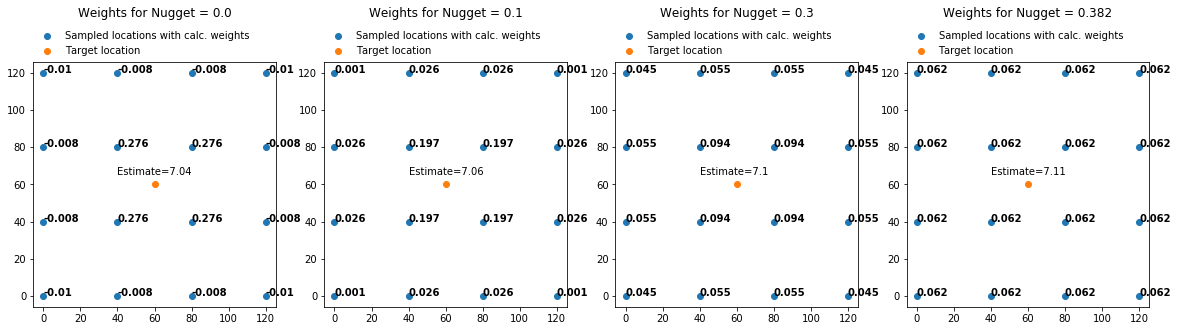

In [7]:
# Plot example case
fig = plt.figure(figsize=(20,4.5))
ax = fig.subplots(1,4)

ax[0].set_title('Weights for Nugget = 0.0', pad=45)
ax[1].set_title('Weights for Nugget = 0.1', pad=45)
ax[2].set_title('Weights for Nugget = 0.3', pad=45)
ax[3].set_title('Weights for Nugget = 0.382', pad=45)

for i in range(0,4,1):
    ax[i].scatter(data[:,0],data[:,1], label='Sampled locations with calc. weights')
    ax[i].scatter(target[:,0],target[:,1], label='Target location')
    ax[i].legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=1, 
            borderaxespad=0, frameon=False)
    ax[i].axis('equal')


nuggets = np.array([0,0.1,0.3,0.382])
for j in range(0,4,1):
    # calcualte result
    test_res, test_var, w = ordinary_kriging(dist_target_to_all[0], dist_all_to_all, data[:,2], 90.53, 0.382, nuggets[j])
    est = np.round(test_res, 2)
    ax[j].text(40,65, f'Estimate={est}')
    
    for i, txt in enumerate(np.round(w[:-1],3)):
        ax[j].annotate(txt, (data[:,0][i],data[:,1][i]),weight='bold')

## Example B) Changing the range

In this example the range of the used variogram is increased incrementally. The total sill of the nested variogram is fixed at 0.382 without a nugget effect. Four different values for the range will be considered:
a) range = 133.33, b) range = 67.73, c) range = 26.66 d) range = 6.66. The corresponding nested variograms (exponential + nugget) are shown here:

Text(0.5, 1.0, 'Nested variograms with varying nugget variance')

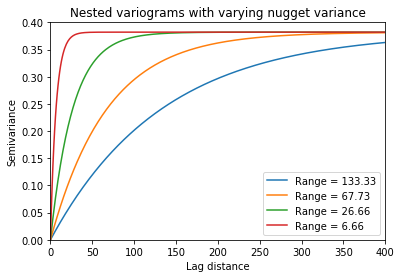

In [8]:
# Plot variograms
d = np.arange(0,400,1)
ranges = np.array([133.33, 67.73, 26.66, 6.66])
plt.plot(d, exponential_variogram_model(d, range_=ranges[0], sill=0.382, nugget=0), label="Range = 133.33")
plt.plot(d, exponential_variogram_model(d, range_=ranges[1], sill=0.382, nugget=0), label="Range = 67.73")
plt.plot(d, exponential_variogram_model(d, range_=ranges[2], sill=0.382, nugget=0), label="Range = 26.66")
plt.plot(d, exponential_variogram_model(d, range_=ranges[3], sill=0.382, nugget=0), label="Range = 6.66")
plt.xlim(0,400)
plt.ylim(0,0.4)
plt.legend()
plt.ylabel('Semivariance')
plt.xlabel('Lag distance')
plt.title('Nested variograms with varying nugget variance')

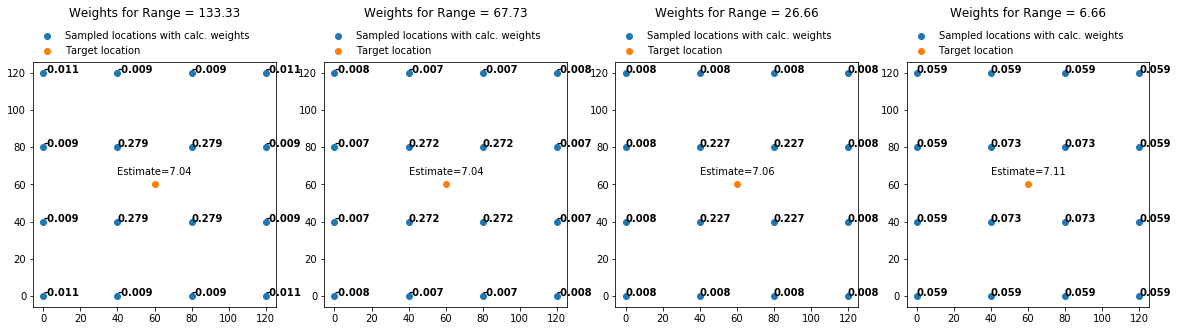

In [9]:
# Plot example case
fig = plt.figure(figsize=(20,4.5))
ax = fig.subplots(1,4)

ax[0].set_title('Weights for Range = 133.33', pad=45)
ax[1].set_title('Weights for Range = 67.73', pad=45)
ax[2].set_title('Weights for Range = 26.66', pad=45)
ax[3].set_title('Weights for Range = 6.66', pad=45)

for i in range(0,4,1):
    ax[i].scatter(data[:,0],data[:,1], label='Sampled locations with calc. weights')
    ax[i].scatter(target[:,0],target[:,1], label='Target location')
    ax[i].legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=1, 
            borderaxespad=0, frameon=False)
    ax[i].axis('equal')


nuggets = np.array([0,0.1,0.3,0.382])
for j in range(0,4,1):
    # calcualte result
    test_res, test_var, w = ordinary_kriging(dist_target_to_all[0], dist_all_to_all, data[:,2], ranges[j], 0.382, 0)
    est = np.round(test_res, 2)
    ax[j].text(40,65, f'Estimate={est}')
    
    for i, txt in enumerate(np.round(w[:-1],3)):
        ax[j].annotate(txt, (data[:,0][i],data[:,1][i]),weight='bold')

## Comparison Pykrige 

For comparison the same calcualtion can be tested with pykrige. An example is shown in the following cells.

In [10]:
# set sill, range (practical!), nugget
par = list((0.382, 90.53*3, 0.382))

OK = OrdinaryKriging(data[:, 0], data[:, 1], data[:, 2], variogram_model='exponential', variogram_parameters=par,
                     verbose=False, enable_plotting=False)

z, ss = OK.execute('points', np.array([60.]), np.array([60.]),backend='loop')

In [11]:
print(z)
print(ss)

[7.1125]
[0.405875]
